# Exploring Price and SEC data for a single company

## Objectives:

- Explore data and feature relationships within a single company, over time
- Develop a process that can be repeated for each company in a dataset
    - Decide if I want to work with a specific time frame or "whatever is available for this company". Is it better to do analysis on all the observations or to make the dataset for each company as much like the others as I can?
- Add calculated fields as necessary for analysis ratios, as in price/earnings or price/book, etc

## Recap of project questions:

- My core question so far is, are market prices correlated with valuation information in some fashion?
    - If so, which valuation information is most strongly correlated?
    - What, if any, is the relationship between stock price/market capitalization and the business's balance sheet?
    - Do any of these data include attempts to put a value on intangibles such as goodwill/reputation?
    - The fundamental analysis tradition focuses on ratios of price to earnings, book value, earnings growth; do the ratios that investors find acceptable change over time? Do they tend to change back (or ahead) when SEC filings are released?
    - (Do I have time for this?) What happens in the periods between filings? Do prices maintain a range, like the moving average support/resistance bands favored by technical analysis?

## Last time on data wrangling...

- I produced a CSV file containing a combination of SEC filing data with stock price data for each of the date of filing, the date before, and the date after the filing.
- Some filings will be missing the "before" or "after" prices, most likely due to the filing date falling on a Friday or Monday; for the sake of the project I have accepted this as not problematic enough (yet) to be worth the work to figure out how to query for data in a way that says "give me the date immediately before this, and if you don't find that date, then go back 3 days instead".
- Price data may be "interesting" to work with in this format, as I have essentially created a tiny time series within each point of a much larger and less granular time series.

## New questions:

- Can I compare my sets of 3-day prices to each other? 
    - Are there patterns that seem consistent? As a guess, do prices often go up or down the day of an SEC release? Do they tend to sustain any changes through the day after? What about the magnitude of the differences?
- How do I best account for the "over time" qualities of this data?
    - https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
    - https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
- I am also interested in the scale of changes from one time point to another, such as, if the company's asset value has changed by x% between the previous filing and the current one, does the stock price change by a similar percentage?

### 1. Import modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from cycler import cycler

In [2]:
df = pd.read_csv('hf-3-day-prices.csv', parse_dates=['date', 'date_minus1', 'date_plus1'])
# df.head()

In [3]:
df_ticker = df[df['ticker'] == 'AAPL']
# df_ticker.head()

In [4]:
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 36 to 74
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            39 non-null     object        
 1   date                              39 non-null     datetime64[ns]
 2   commonstocksharesissued           39 non-null     float64       
 3   assetscurrent                     39 non-null     float64       
 4   accountspayablecurrent            39 non-null     float64       
 5   commonstockvalue                  24 non-null     float64       
 6   liabilities                       39 non-null     float64       
 7   liabilitiesandstockholdersequity  39 non-null     float64       
 8   stockholdersequity                39 non-null     float64       
 9   earningspersharebasic             39 non-null     float64       
 10  netincomeloss                     39 non-null     f

In [5]:
# To reduce complexity, drop null columns:
df_ticker = df_ticker.dropna(axis='columns', how='all')
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 36 to 74
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            39 non-null     object        
 1   date                              39 non-null     datetime64[ns]
 2   commonstocksharesissued           39 non-null     float64       
 3   assetscurrent                     39 non-null     float64       
 4   accountspayablecurrent            39 non-null     float64       
 5   commonstockvalue                  24 non-null     float64       
 6   liabilities                       39 non-null     float64       
 7   liabilitiesandstockholdersequity  39 non-null     float64       
 8   stockholdersequity                39 non-null     float64       
 9   earningspersharebasic             39 non-null     float64       
 10  netincomeloss                     39 non-null     f

### 2. Start visualizing!

<AxesSubplot:>

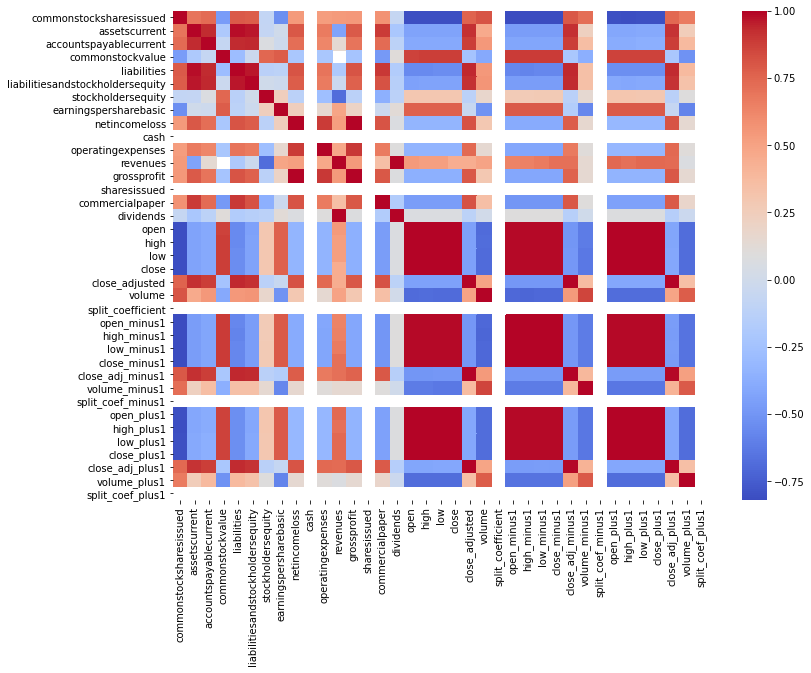

In [6]:
# still too many columns for pairplot. Let's try heatmap.
corrmap = df_ticker.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(round(corrmap,2), ax=ax, cmap="coolwarm")

Well, this is an interesting quilt pattern. I didn't expect these patterns of... correlation flips, I guess I would call it. 
- I didn't expect the various price columns to be so universally 100% positive with their alternate days.
- I didn't expect prices to be so often negatively correlated to filing data, and especially not for the correlations to all reverse for close_adj and volume columns
- It might be naive, on reflection, that I was surprised by the strong positive associations between business assets and liabilities. I have a sense, although I can't cite sources off the top of my head, that businesses are generally encouraged to keep debts as nearly in sync with their assets as lenders will allow, as a way to turn the value of illiquid assets into money the business can use more immediately.
- I would say the correlations between 'commonstocksharesissued' and 'commonstockvalue', especially vis-a-vis prices, are basically a given. However, I wonder if even this relationship might change in scale when viewed over time?
- I'm also surprised at how nearly uncorrelated dividends are to just about everything else on the board.

Is there a good way to explore some of these relationships over time, preferably in subsets so I don't bury myself in plots?

#### Plot close price vs 'close_adjusted' over time. Does that help tell me why they are oppositely correlated to most filing data?

No handles with labels found to put in legend.


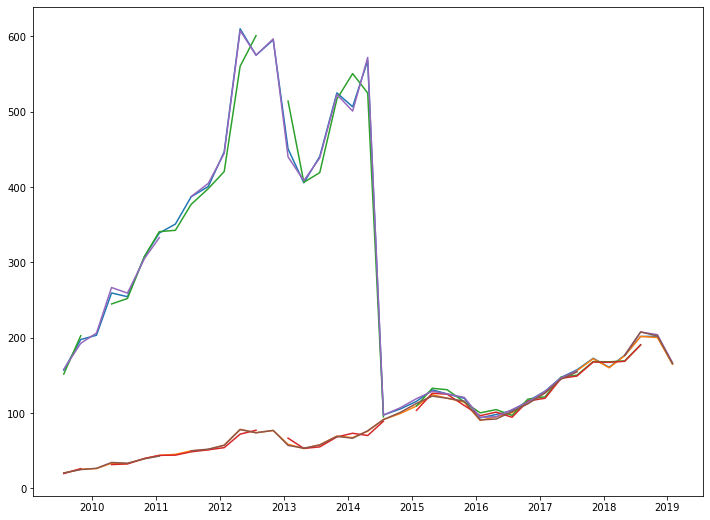

In [7]:
x = df_ticker[['date']]
y = df_ticker[['close', 'close_adjusted']]
y_minus = df_ticker[['close_minus1', 'close_adj_minus1']]
y_plus = df_ticker[['close_plus1', 'close_adj_plus1']]

cc = (cycler(color=list('rgb')) * cycler(linestyle=['-', '--']))
plt.subplots(figsize=(12, 9))
plt.plot(x, y)
plt.plot(x, y_minus)
plt.plot(x, y_plus)
plt.rc('axes', prop_cycle=cc)
ax.legend(loc='upper right')
plt.show()

Again, not what I expected. Some kind of big stock split in 2014? That would explain a bunch of the correlation weirdness.

In [8]:
df_2014 = df_ticker[df_ticker['date'].dt.year == 2014]
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 54 to 57
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            4 non-null      object        
 1   date                              4 non-null      datetime64[ns]
 2   commonstocksharesissued           4 non-null      float64       
 3   assetscurrent                     4 non-null      float64       
 4   accountspayablecurrent            4 non-null      float64       
 5   commonstockvalue                  1 non-null      float64       
 6   liabilities                       4 non-null      float64       
 7   liabilitiesandstockholdersequity  4 non-null      float64       
 8   stockholdersequity                4 non-null      float64       
 9   earningspersharebasic             4 non-null      float64       
 10  netincomeloss                     4 non-null      fl

In [9]:
df_2014['commonstocksharesissued']

54    8.924470e+08
55    8.992130e+05
56    6.294494e+09
57    5.866161e+09
Name: commonstocksharesissued, dtype: float64

In [10]:
df_2014['split_coefficient']
df_2014['split_coef_plus1']

54    1.0
55    1.0
56    1.0
57    1.0
Name: split_coef_plus1, dtype: float64

In [11]:
df_2014['close']

54    506.50
55    567.77
56     97.19
57    105.11
Name: close, dtype: float64

Price data doesn't seem to be recognizing it as a split and the shares issued numbers are pretty wierd. 8.92e+08, down to e+05, up to 6.29e+09... the jump up matches the price change, is the second figure an error?

In [12]:
df_2013 = df_ticker[df_ticker['date'].dt.year == 2013]
df_2013['commonstocksharesissued']

50    939208000.0
51    939208000.0
52    939208000.0
53    939208000.0
Name: commonstocksharesissued, dtype: float64

In [13]:
df_ticker[df_ticker['date'].dt.year.isin([2013, 2014])]

ticker       date  commonstocksharesissued  assetscurrent  \
50   AAPL 2013-01-24             9.392080e+08   5.765300e+10   
51   AAPL 2013-04-24             9.392080e+08   5.765300e+10   
52   AAPL 2013-07-24             9.392080e+08   5.765300e+10   
53   AAPL 2013-10-30             9.392080e+08   5.765300e+10   
54   AAPL 2014-01-28             8.924470e+08   8.034700e+10   
55   AAPL 2014-04-24             8.992130e+05   7.328600e+10   
56   AAPL 2014-07-23             6.294494e+09   7.328600e+10   
57   AAPL 2014-10-27             5.866161e+09   6.853100e+10   

    accountspayablecurrent  commonstockvalue   liabilities  \
50            2.117500e+10      1.642200e+10  5.785400e+10   
51            2.117500e+10      1.642200e+10  5.785400e+10   
52            2.117500e+10      1.642200e+10  5.785400e+10   
53            2.117500e+10      1.642200e+10  5.785400e+10   
54            2.958800e+10      2.055900e+10  9.550000e+10   
55            2.236700e+10               NaN  8.345100e+10   
56            2.236700e+10               NaN  8.345100e+10   
57            3.019600e+10               NaN  1.202920e+11   

    liabilitiesandstockholdersequity  stockholdersequity  \
50                      1.760640e+11        1.182100e+11   
51                      1.760640e+11        1.182100e+11   
52                      1.760640e+11        1.182100e+11   
53                      1.760640e+11        4.990000e+08   
54                      2.251840e+11        1.296840e+11   
55                      2.070000e+11        1.235490e+11   
56                      2.070000e+11        1.235490e+11   
57                      2.318390e+11        2.331300e+10   

    earningspersharebasic  ...  volume_minus1  split_coef_minus1  date_plus1  \
50                  14.03  ...     30768200.0                1.0  2013-01-25   
51                  10.16  ...     23722800.0                1.0  2013-04-25   
52                   7.51  ...     13192700.0                1.0  2013-07-25   
53                  14.03  ...     22707400.0                1.0  2013-10-31   
54                  14.59  ...     19817100.0                1.0  2014-01-29   
55                  11.69  ...     14105000.0                1.0  2014-04-25   
56                   1.29  ...     55197000.0                1.0  2014-07-24   
57                   1.43  ...            NaN                NaN  2014-10-28   

    open_plus1  high_plus1  low_plus1  close_plus1  close_adj_plus1  \
50     451.690      456.23     435.00      439.880          56.8367   
51     411.225      413.94     407.00      408.380          53.0652   
52     440.700      441.40     435.81      438.500          57.3595   
53     525.000      527.49     521.27      522.702          68.8262   
54     503.950      507.37     498.62      500.750          66.3218   
55     564.530      571.99     563.96      571.940          76.2013   
56      97.035       97.32      96.42       97.030          90.9996   
57     105.400      106.74     105.35      106.740         100.6042   

    volume_plus1  split_coef_plus1  
50    43143800.0               1.0  
51    13744200.0               1.0  
52     8196200.0               1.0  
53     9846300.0               1.0  
54    17957500.0               1.0  
55    13938400.0               1.0  
56    45729000.0               1.0  
57    48060949.0               1.0  

[8 rows x 41 columns]

https://investor.apple.com/faq/default.aspx#:~:text=Apple's%20stock%20has%20split%20five,%2C%20and%20June%2016%2C%201987.
Says yes, there was a 7-for-1 split in June 2014.

Looking at the CSV, I think the April 2014 share number is a typo; numbers both before and after end in a round thousand, but this one is missing the 3 trailing 0's.

If I understand split adjusting correctly, I should only use the "adjusted" price numbers, which means tossing out all the open/high/low/close columns. (Simpler data might not be such a bad thing...)

If I understand the "split coefficient" correctly it should not be 1.0 all this time. If it is, it's kind of useless.

In [14]:
df_ticker.split_coefficient.unique()

array([1.])

In [15]:
df_ticker.split_coef_minus1.unique()

array([ 1., nan])

In [16]:
df_ticker.split_coef_plus1.unique()

array([ 1., nan])

In [17]:
dropcols = ['open', 'high', 'low', 'close', 'split_coefficient', 'open_minus1', 'high_minus1', 'low_minus1', 'close_minus1', 
            'split_coef_minus1', 'open_plus1', 'high_plus1', 'low_plus1', 'close_plus1', 'split_coef_plus1']
df_ticker = df_ticker.drop(dropcols, axis=1)
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 36 to 74
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            39 non-null     object        
 1   date                              39 non-null     datetime64[ns]
 2   commonstocksharesissued           39 non-null     float64       
 3   assetscurrent                     39 non-null     float64       
 4   accountspayablecurrent            39 non-null     float64       
 5   commonstockvalue                  24 non-null     float64       
 6   liabilities                       39 non-null     float64       
 7   liabilitiesandstockholdersequity  39 non-null     float64       
 8   stockholdersequity                39 non-null     float64       
 9   earningspersharebasic             39 non-null     float64       
 10  netincomeloss                     39 non-null     f

<AxesSubplot:>

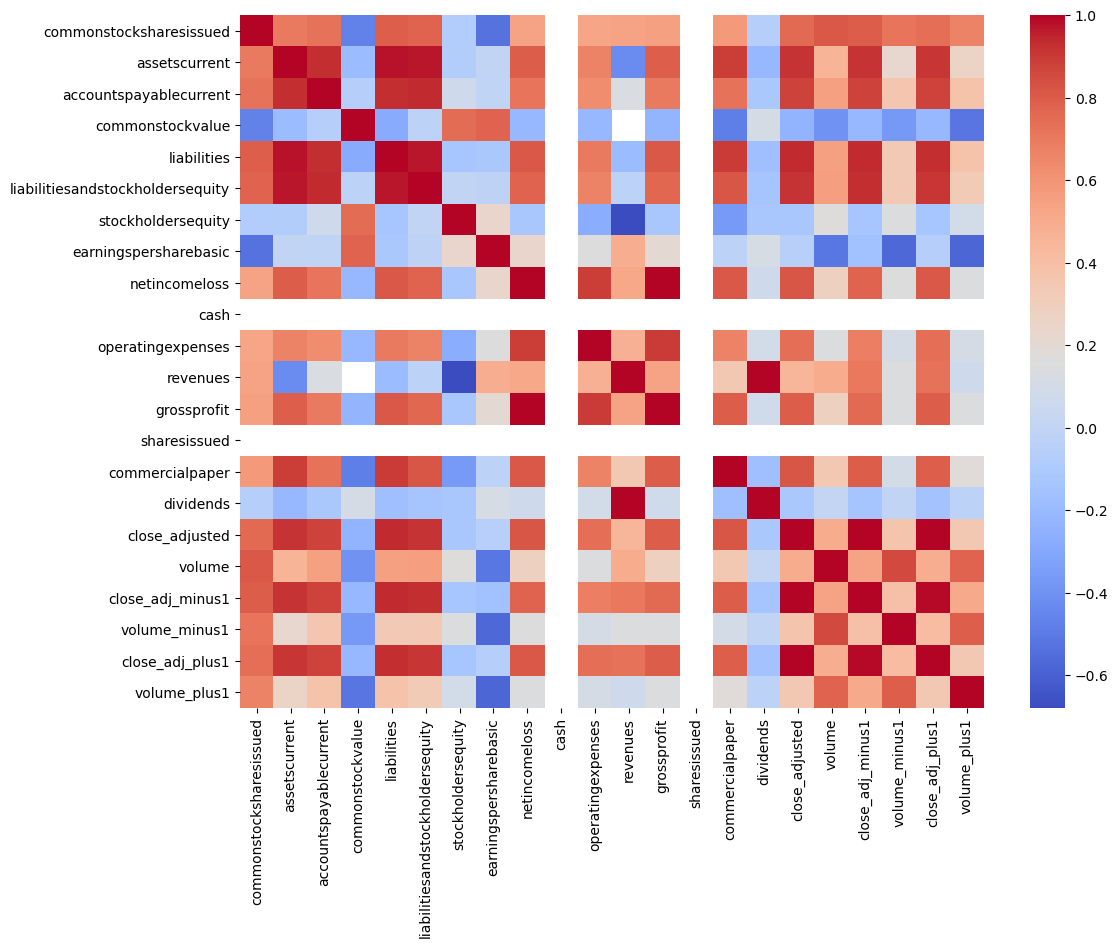

In [18]:
plt.rcdefaults()
corrmap = df_ticker.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(round(corrmap,2), ax=ax, cmap="coolwarm")

I wonder why, of the columns with few values, 'cash' and 'sharesissued' are coming out blank but 'revenues' gets a correlation on only 5 non-null rows?

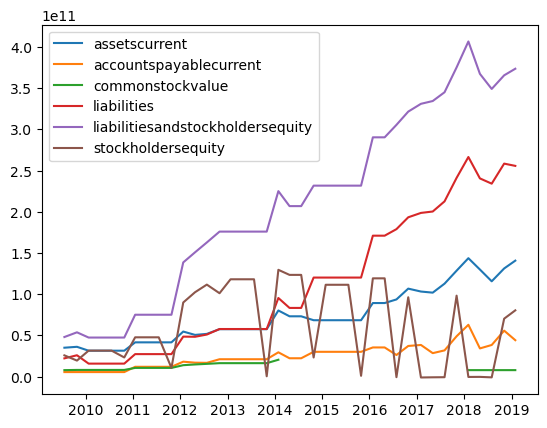

In [19]:
# let's try plotting subsets of columns over time. 
# picking a group with somewhat similar scales, although maybe I should show these in log scale?
columns = list(df_ticker.columns.values)
ss1 = columns[3:9]
y = df_ticker[ss1]
plt.plot(x, y)
plt.legend(labels = ss1)
plt.show()

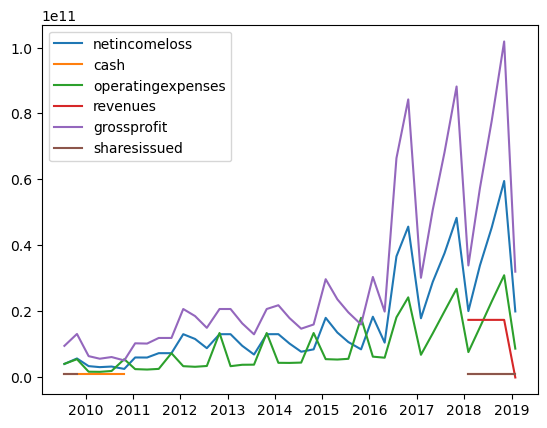

In [20]:
ss2 = columns[10:16]
y = df_ticker[ss2]
plt.plot(x, y)
plt.legend(labels = ss2)
plt.show()

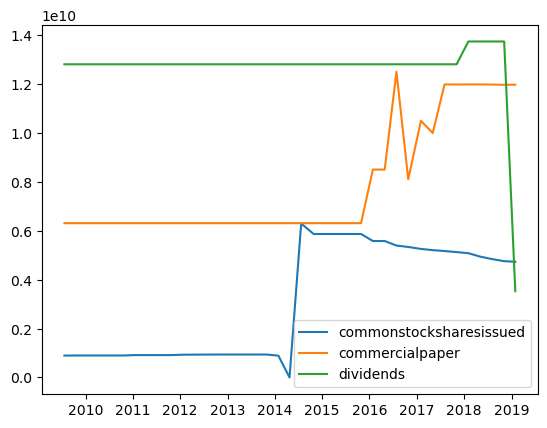

In [21]:
ss3 = ['commonstocksharesissued'] + columns[16:18]
y = df_ticker[ss3]
plt.plot(x, y)
plt.legend(labels = ss3)
plt.show()

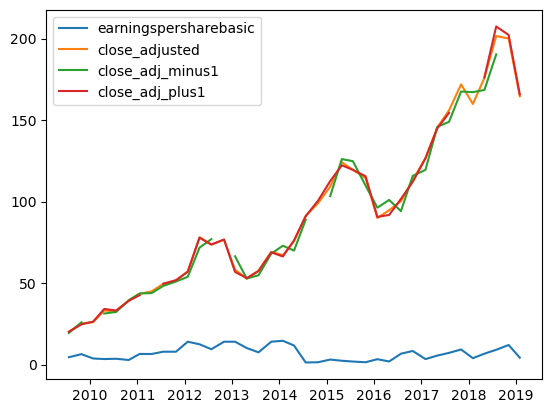

In [22]:
ss4 = ['earningspersharebasic', 'close_adjusted', 'close_adj_minus1', 'close_adj_plus1']
y = df_ticker[ss4]
plt.plot(x, y)
plt.legend(labels = ss4)
plt.show()

I see some interesting trends, and I think I'm getting a bit off track. 
- Is the "over time" part more or less important than the "correlation" part? 
- Stockholders' equity looks like it's trending downward since 2014
- By eyeball, the price/earnings ratio has skyrocketed... on earnings that are flat-to-falling over time
- Liabilities seem to be going up faster than assets
- Gross profit has leaped in the last 3 years but very volatile. Net income and operating expenses showing similar increases.
- As I get further into details, it's getting hard to think how I would repeat this process for multiple companies.

## Mentor review:
- Look for some tickers that have more reporting (especially revenue)
- Try the linear regressions
- Try statistical tests (normality; histograms)
- See if multiple companies in a sector are workable (top 5 and/or most complete data)

#### Look for some tickers that have more reporting (especially revenue), and
#### See if multiple companies in a sector are workable (top 5 and/or most complete data)
Limiting to "tech stocks" since multi-company comparisons ought to account for industry

In [23]:
print(df.ticker.unique())

['AAL' 'AAPL' 'ABBV' 'ABC' 'ACI' 'ADM' 'AIG' 'ALL' 'AMZN' 'ANTM' 'AXP'
 'BA' 'BAC' 'BBY' 'CAH' 'CAT' 'CHTR' 'CI' 'CNC' 'COF' 'COP' 'COST' 'CSCO'
 'CVS' 'CVX' 'DAL' 'DE' 'DOW' 'EXC' 'F' 'FB' 'FDX' 'GD' 'GE' 'GM' 'GOOGL'
 'HCA' 'HD' 'HON' 'HPQ' 'HUM' 'IBM' 'INT' 'INTC' 'JNJ' 'KO' 'KR' 'LMT'
 'LOW' 'MCK' 'MET' 'MPC' 'MRK' 'MS' 'MSFT' 'NKE' 'NOC' 'ORCL' 'PAGP' 'PEP'
 'PFE' 'PG' 'PGR' 'PRU' 'PSX' 'SYY' 'T' 'TECD' 'TGT' 'TJX' 'TSN' 'UAL'
 'UNH' 'UPS' 'VLO' 'VZ' 'WBA' 'WFC' 'WMT' 'XOM']


In [24]:
tech_stocks = ['AAPL', 'AMZN', 'CSCO', 'FB', 'GOOGL', 'HPQ', 'IBM', 'INTC', 'MSFT', 'ORCL']
dftech = df[df['ticker'].isin(tech_stocks)]
dftech.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 36 to 1983
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            359 non-null    object        
 1   date                              359 non-null    datetime64[ns]
 2   commonstocksharesissued           278 non-null    float64       
 3   assetscurrent                     359 non-null    float64       
 4   accountspayablecurrent            359 non-null    float64       
 5   commonstockvalue                  83 non-null     float64       
 6   liabilities                       203 non-null    float64       
 7   liabilitiesandstockholdersequity  359 non-null    float64       
 8   stockholdersequity                359 non-null    float64       
 9   earningspersharebasic             359 non-null    float64       
 10  netincomeloss                     359 non-null  

In [25]:
dftech.groupby('ticker').revenues.count()

ticker
AAPL      5
AMZN      5
CSCO     36
FB       28
GOOGL    14
HPQ      38
IBM      40
INTC      1
MSFT     12
ORCL     39
Name: revenues, dtype: int64

In [26]:
dftech.groupby('ticker').date.count() # for comparison, total number of records per ticker

ticker
AAPL     39
AMZN     40
CSCO     40
FB       28
GOOGL    14
HPQ      38
IBM      40
INTC     39
MSFT     42
ORCL     39
Name: date, dtype: int64

In [27]:
# most complete revenues data
tech_revenues = ['CSCO', 'FB', 'GOOGL', 'HPQ', 'IBM', 'ORCL']
df_tech_rev = df[df['ticker'].isin(tech_revenues)]
df_tech_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  19 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

In [28]:
# drop null columns
df_tech_rev = df_tech_rev.dropna(axis='columns', how='all')

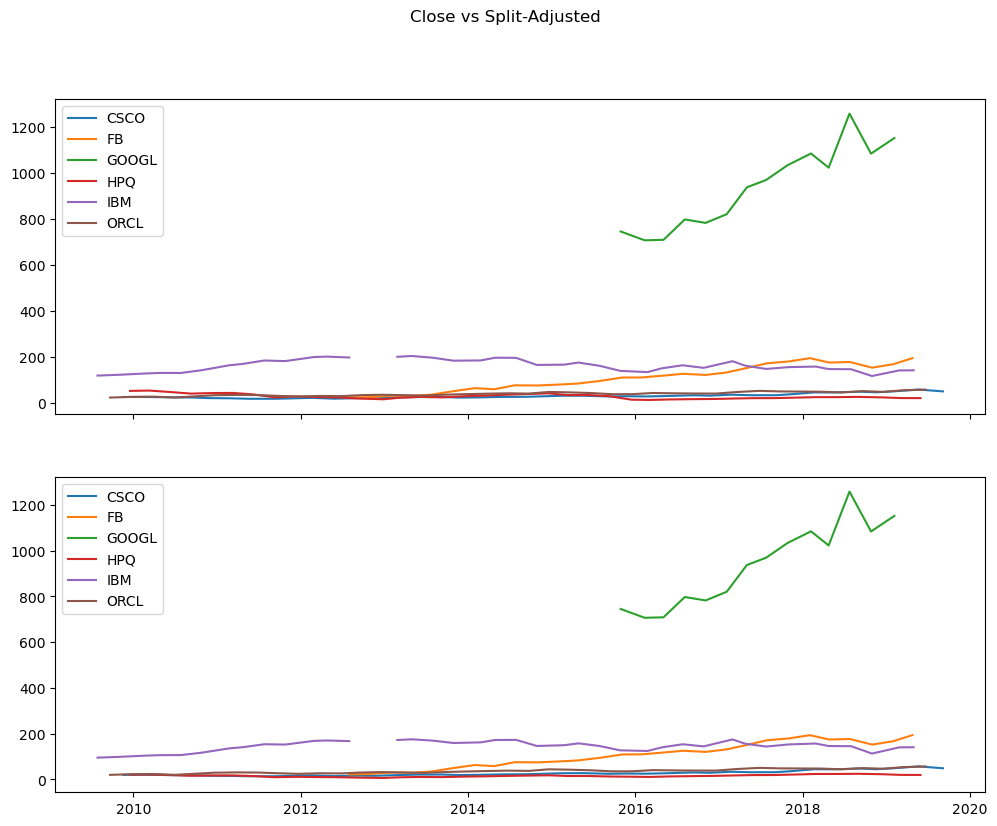

In [29]:
# check for split adjustments
fig, axs = plt.subplots(2, sharex=True, figsize=(12, 9))
fig.suptitle('Close vs Split-Adjusted')
for key, grp in df_tech_rev.groupby(['ticker']):
    axs[0].plot(grp['date'], grp['close'], label=key)
    axs[1].plot(grp['date'], grp['close_adjusted'], label=key)
    # credit: https://stackoverflow.com/questions/41494942/pandas-dataframe-groupby-plot
axs[0].ylabel = 'Close'
axs[1].ylabel = 'Adjusted Close'
plt.xlabel = 'Date'
axs[0].legend()
axs[1].legend()
plt.show()

<AxesSubplot:>

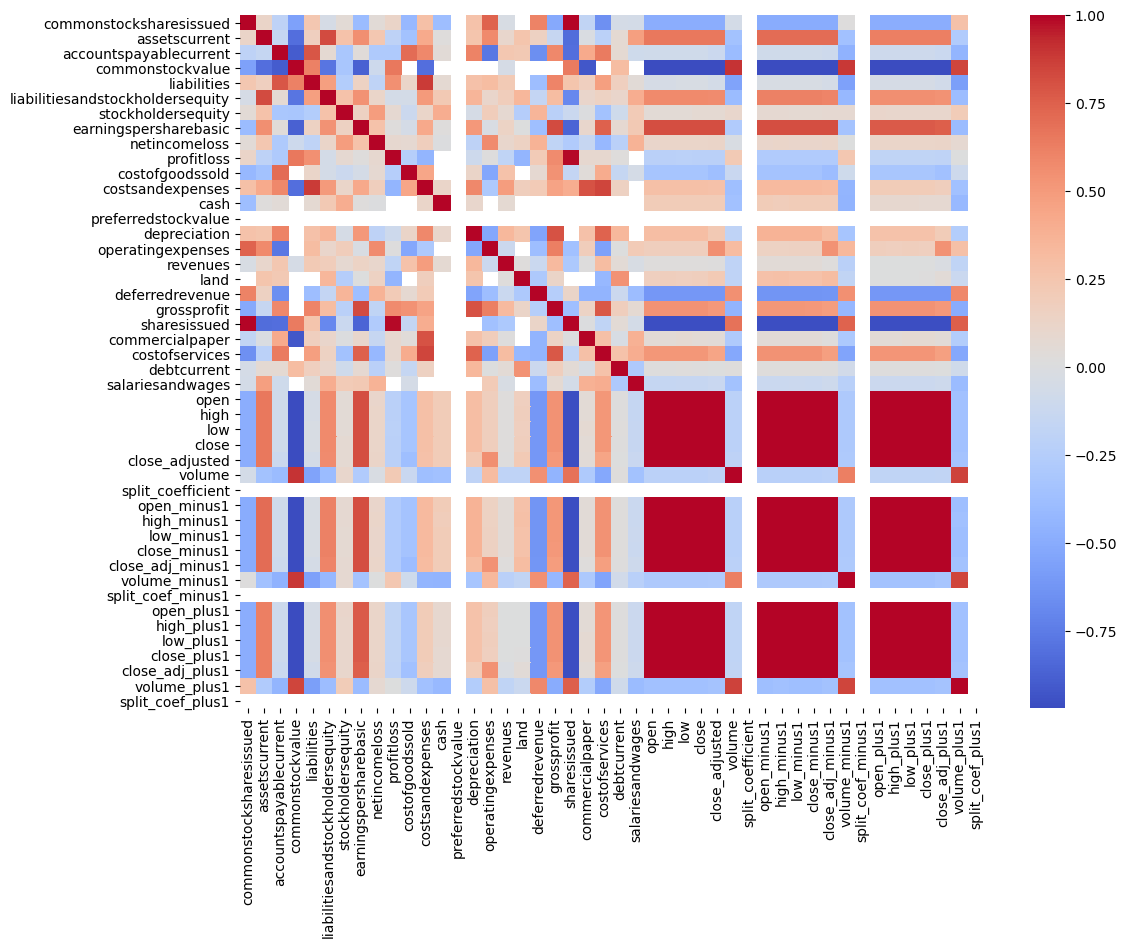

In [30]:
# doesn't look like there were any big split events. How's the heatmap?
corrmap = df_tech_rev.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(round(corrmap,2), ax=ax, cmap="coolwarm")

In [31]:
df_tech_rev.split_coefficient.unique()

array([ 1., nan])

In [32]:
df_tech_rev.split_coef_minus1.unique()

array([ 1., nan])

In [33]:
df_tech_rev.split_coef_plus1.unique()

array([ 1., nan])

In [34]:
# drop split coefficient, still not informational
dropcols = ['split_coefficient', 'split_coef_minus1', 'split_coef_plus1']
df_tech_rev = df_tech_rev.drop(dropcols, axis=1)

#### Try statistical tests (normality; histograms)

In [35]:
df_tr_numeric = df_tech_rev.select_dtypes(include=np.float64)
df_tr_numeric.shape

(199, 43)

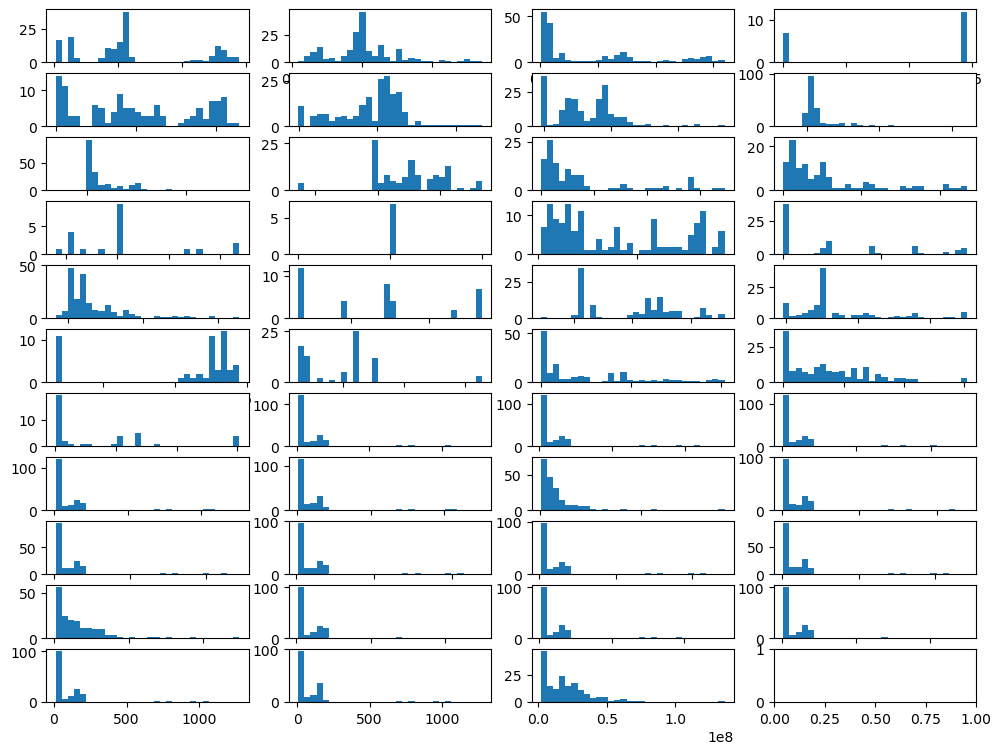

In [36]:
# axes credit: https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
n_cols = 4
n_rows = int(round(df_tr_numeric.shape[1]/n_cols, 0))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 9))
n_bins = 30

for i, ax in enumerate(axes.flat):
    if i in range(df_tr_numeric.shape[1]):
        ax.hist(df_tr_numeric.iloc[:,i], bins=n_bins)
        ax.xlabel = df_tr_numeric.columns[i]
        # ax.ylabel = 'Count'
   
# fig.tight_layout
plt.show()

So... even with multiple similar-sector companies, 43 tiny unlabeled plots don't look normal at all. 
Also I would probably do better to group these by columns with similar data ranges, but I don't want to spend all week on this.

In [37]:
# normality testing credit: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
# Shapiro-Wilk test
for col in df_tr_numeric.columns:
    print(col)
    stat, p = stats.shapiro(df_tr_numeric[col].notnull())
    print('Statistic=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

commonstocksharesissued
Statistic=0.485, p=0.000
Sample does not look Gaussian (reject H0)
assetscurrent
Statistic=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)
accountspayablecurrent
Statistic=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)
commonstockvalue
Statistic=0.333, p=0.000
Sample does not look Gaussian (reject H0)
liabilities
Statistic=0.618, p=0.000
Sample does not look Gaussian (reject H0)
liabilitiesandstockholdersequity
Statistic=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)
stockholdersequity
Statistic=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)
earningspersharebasic
Statistic=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)
netincomeloss
Statistic=1.000, p=1.000
Sample looks Gaussian (fail to reject H0)
profitloss
Statistic=0.614, p=0.000
Sample does not look Gaussian (reject H0)
costofgoodssold
Statistic=0.631, p=0.000
Sample does not look Gaussian (reject H0)
costsandexpenses
Statistic=0.622, p=0.000
Sample does not 

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


I am suspicious of the columns where the "statistic" and p are both 1.000.
- assetscurrent
- accountspayablecurrent
- liabilitiesandstockholdersequity
- stockholdersequity
- earningspersharebasic
- netincomeloss

Let's see what the other tests say. I might want to run these columns through testing without the .notnull() before I make a firm decision.

In [38]:
# D’Agostino’s K^2 Test
for col in df_tr_numeric.columns:
    print(col)
    stat, p = stats.normaltest(df_tr_numeric[col].notnull())
    print('Statistic=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

commonstocksharesissued
Statistic=48.638, p=0.000
Sample does not look Gaussian (reject H0)
assetscurrent
Statistic=730.133, p=0.000
Sample does not look Gaussian (reject H0)
accountspayablecurrent
Statistic=730.133, p=0.000
Sample does not look Gaussian (reject H0)
commonstockvalue
Statistic=125.330, p=0.000
Sample does not look Gaussian (reject H0)
liabilities
Statistic=1346.033, p=0.000
Sample does not look Gaussian (reject H0)
liabilitiesandstockholdersequity
Statistic=730.133, p=0.000
Sample does not look Gaussian (reject H0)
stockholdersequity
Statistic=730.133, p=0.000
Sample does not look Gaussian (reject H0)
earningspersharebasic
Statistic=730.133, p=0.000
Sample does not look Gaussian (reject H0)
netincomeloss
Statistic=730.133, p=0.000
Sample does not look Gaussian (reject H0)
profitloss
Statistic=1437.323, p=0.000
Sample does not look Gaussian (reject H0)
costofgoodssold
Statistic=1135.061, p=0.000
Sample does not look Gaussian (reject H0)
costsandexpenses
Statistic=1252.64

No normals here! I'm in good company! Although my suspicious columns from before all have the same statistic number.

In [39]:
# Anderson-Darling Test
for col in df_tr_numeric.columns:
    print(col)
    result = stats.anderson(df_tr_numeric[col].notnull())
    print('Statistic=%.3f' % result.statistic)
    # interpret
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


commonstocksharesissued
Statistic=53.336
15.000: 0.565, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.772, data does not look normal (reject H0)
2.500: 0.900, data does not look normal (reject H0)
1.000: 1.071, data does not look normal (reject H0)
assetscurrent
Statistic=nan
15.000: 0.565, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.772, data does not look normal (reject H0)
2.500: 0.900, data does not look normal (reject H0)
1.000: 1.071, data does not look normal (reject H0)
accountspayablecurrent
Statistic=nan
15.000: 0.565, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.772, data does not look normal (reject H0)
2.500: 0.900, data does not look normal (reject H0)
1.000: 1.071, data does not look normal (reject H0)
commonstockvalue
Statistic=66.067
15.000: 0.565, data does not look normal (reject H0)
10.000: 0.643, data d

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


Trouble with the same group of columns. Let's see what happens if I test them by themselves. The first time I tried the Shapiro test, I didn't realize I needed to drop nulls, and I got different results on the few columns that have no nulls.

In [40]:
coltest = ['assetscurrent', 'accountspayablecurrent', 'liabilitiesandstockholdersequity', 
           'stockholdersequity', 'earningspersharebasic', 'netincomeloss']
df_coltest = df_tr_numeric[coltest]
df_coltest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   assetscurrent                     199 non-null    float64
 1   accountspayablecurrent            199 non-null    float64
 2   liabilitiesandstockholdersequity  199 non-null    float64
 3   stockholdersequity                199 non-null    float64
 4   earningspersharebasic             199 non-null    float64
 5   netincomeloss                     199 non-null    float64
dtypes: float64(6)
memory usage: 10.9 KB


In [41]:
# rerun tests without .notnull for columns with no null values
for col in df_coltest.columns:
    print(col)
    stat, p = stats.shapiro(df_coltest[col])
    # interpret Shapiro
    alpha = 0.05
    if p > alpha:
        print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
    else:
        print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
    stat, p = stats.normaltest(df_coltest[col])
    # interpret D'Agostino
    alpha = 0.05
    if p > alpha:
        print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
    else:
        print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
    result = stats.anderson(df_coltest[col])
    print('Anderson Statistic=%.3f' % result.statistic)
    # interpret Anderson
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

assetscurrent
Shapiro Statistic=0.925, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=28.829, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=4.876
15.000: 0.565, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.772, data does not look normal (reject H0)
2.500: 0.900, data does not look normal (reject H0)
1.000: 1.071, data does not look normal (reject H0)
accountspayablecurrent
Shapiro Statistic=0.791, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=27.451, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=16.709
15.000: 0.565, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.772, data does not look normal (reject H0)
2.500: 0.900, data does not look normal (reject H0)
1.000: 1.071, data does not look normal (reject H0)
liabilitiesandstockholdersequity
Shapiro Statistic=0.948, p=0.000 Sample does no

Yup, for some reason results are different when I don't try to drop nulls that don't exist in these columns. And nothing is normal.

#### Try the linear regressions

I'll try one, or at least plot one, since it's pretty clear that my data is not normal.

<AxesSubplot:xlabel='revenues', ylabel='close'>

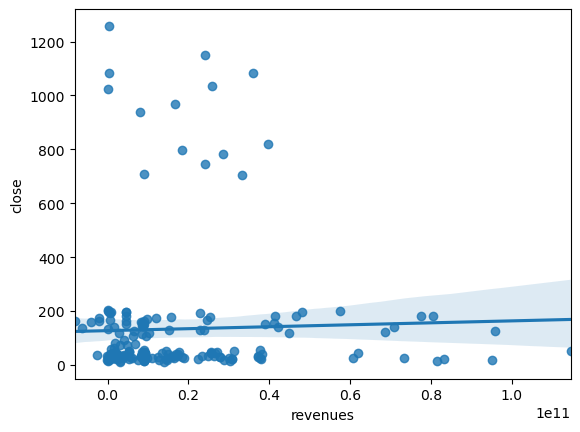

In [42]:
sns.regplot(x='revenues', y='close', data=df_tr_numeric)

hm. Is that the Google prices throwing everything else off?

In [43]:
test = df_tech_rev[df_tech_rev['ticker'] != 'GOOGL']
test.ticker.unique()
test = test.select_dtypes(include=np.float64)

In [44]:
# rerun normality tests without Google
for col in test.columns:
    print(col)
    stat, p = stats.shapiro(test[col].notnull())
    # interpret Shapiro
    alpha = 0.05
    if p > alpha:
        print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
    else:
        print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
    stat, p = stats.normaltest(test[col].notnull())
    # interpret D'Agostino
    alpha = 0.05
    if p > alpha:
        print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
    else:
        print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
    result = stats.anderson(test[col].notnull())
    print('Anderson Statistic=%.3f' % result.statistic)
    # interpret Anderson
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

commonstocksharesissued
Shapiro Statistic=0.501, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=40.095, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=48.019
15.000: 0.564, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.771, data does not look normal (reject H0)
2.500: 0.899, data does not look normal (reject H0)
1.000: 1.070, data does not look normal (reject H0)
assetscurrent
Shapiro Statistic=1.000, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=696.416, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.564, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.771, data does not look normal (reject H0)
2.500: 0.899, data does not look normal (reject H0)
1.000: 1.070, data does not look normal (reject H0)
accountspayablecurrent
Shapiro Statistic=1.000, p=1.000 Sample looks Gaussian (f

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anacon

In [45]:
test_coltest = test[coltest]
test_coltest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185 entries, 713 to 1983
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   assetscurrent                     185 non-null    float64
 1   accountspayablecurrent            185 non-null    float64
 2   liabilitiesandstockholdersequity  185 non-null    float64
 3   stockholdersequity                185 non-null    float64
 4   earningspersharebasic             185 non-null    float64
 5   netincomeloss                     185 non-null    float64
dtypes: float64(6)
memory usage: 10.1 KB


In [46]:
# re-rerun tests without .notnull for columns with no null values
for col in df_coltest.columns:
    print(col)
    stat, p = stats.shapiro(test_coltest[col])
    # interpret Shapiro
    alpha = 0.05
    if p > alpha:
        print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
    else:
        print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
    stat, p = stats.normaltest(test_coltest[col])
    # interpret D'Agostino
    alpha = 0.05
    if p > alpha:
        print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
    else:
        print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
    result = stats.anderson(test_coltest[col])
    print('Anderson Statistic=%.3f' % result.statistic)
    # interpret Anderson
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

assetscurrent
Shapiro Statistic=0.949, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=2.798, p=0.247 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=4.198
15.000: 0.564, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.771, data does not look normal (reject H0)
2.500: 0.899, data does not look normal (reject H0)
1.000: 1.070, data does not look normal (reject H0)
accountspayablecurrent
Shapiro Statistic=0.786, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=27.842, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=16.325
15.000: 0.564, data does not look normal (reject H0)
10.000: 0.643, data does not look normal (reject H0)
5.000: 0.771, data does not look normal (reject H0)
2.500: 0.899, data does not look normal (reject H0)
1.000: 1.070, data does not look normal (reject H0)
liabilitiesandstockholdersequity
Shapiro Statistic=0.889, p=0.000 Sample does not

Still no normals here! Just for kicks, one regplot...

<AxesSubplot:xlabel='revenues', ylabel='close'>

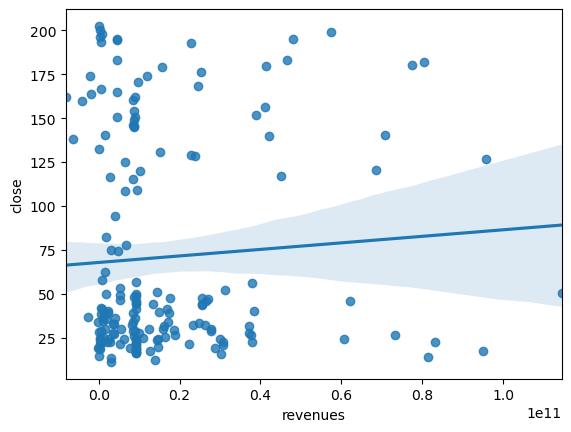

In [47]:
sns.regplot(x='revenues', y='close', data=test)

If anything, the Google outliers made the first regplot look better fitted because they threw the scale off so far.

I'm feeling stubborn today. I will ask if my data seem normal when taken one stock at a time. 

In [48]:
test2 = df_tech_rev[df_tech_rev['ticker'] != 'GOOGL']
test2.ticker.unique()

array(['CSCO', 'FB', 'HPQ', 'IBM', 'ORCL'], dtype=object)

In [49]:
dflist = []
for t in test2.ticker.unique():
    df = test2[test2['ticker'] == t]
    df = df.select_dtypes(include=np.float64)
    dflist.append(df)
    
for df in dflist:
    for col in df.columns:
        print(col)
        if df[col].isnull().any():
            stat, p = stats.shapiro(df[col].notnull())
            # interpret Shapiro
            alpha = 0.05
            if p > alpha:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            stat, p = stats.normaltest(df[col].notnull())
            # interpret D'Agostino
            alpha = 0.05
            if p > alpha:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            result = stats.anderson(df[col].notnull())
            print('Anderson Statistic=%.3f' % result.statistic)
            # interpret Anderson
            for i in range(len(result.critical_values)):
                sl, cv = result.significance_level[i], result.critical_values[i]
                if result.statistic < result.critical_values[i]:
                    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
                else:
                    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
        else:
            stat, p = stats.shapiro(df[col])
            # interpret Shapiro
            alpha = 0.05
            if p > alpha:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            stat, p = stats.normaltest(df[col])
            # interpret D'Agostino
            alpha = 0.05
            if p > alpha:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            result = stats.anderson(df[col])
            print('Anderson Statistic=%.3f' % result.statistic)
            # interpret Anderson
            for i in range(len(result.critical_values)):
                sl, cv = result.significance_level[i], result.critical_values[i]
                if result.statistic < result.critical_values[i]:
                    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
                else:
                    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
            

commonstocksharesissued
Shapiro Statistic=0.955, p=0.112 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=2.614, p=0.271 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.617
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data looks normal (fail to reject H0)
2.500: 0.847, data looks normal (fail to reject H0)
1.000: 1.007, data looks normal (fail to reject H0)
assetscurrent
Shapiro Statistic=0.958, p=0.141 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=3.216, p=0.200 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.470
15.000: 0.531, data looks normal (fail to reject H0)
10.000: 0.605, data looks normal (fail to reject H0)
5.000: 0.726, data looks normal (fail to reject H0)
2.500: 0.847, data looks normal (fail to reject H0)
1.000: 1.007, data looks normal (fail to reject H0)
accountspayablecurrent
Shapiro Statistic=0.788, p=0.000 Sample does not look Gauss

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anacon

earningspersharebasic
Shapiro Statistic=0.789, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=14.090, p=0.001 Sample does not look Gaussian (reject H0)
Anderson Statistic=2.158
15.000: 0.518, data does not look normal (reject H0)
10.000: 0.590, data does not look normal (reject H0)
5.000: 0.708, data does not look normal (reject H0)
2.500: 0.826, data does not look normal (reject H0)
1.000: 0.983, data does not look normal (reject H0)
netincomeloss
Shapiro Statistic=0.574, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=26.667, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=5.143
15.000: 0.518, data does not look normal (reject H0)
10.000: 0.590, data does not look normal (reject H0)
5.000: 0.708, data does not look normal (reject H0)
2.500: 0.826, data does not look normal (reject H0)
1.000: 0.983, data does not look normal (reject H0)
profitloss
Shapiro Statistic=1.000, p=1.000 Sample looks Gaussian (fail to reject 

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anacon


15.000: 0.529, data does not look normal (reject H0)
10.000: 0.603, data does not look normal (reject H0)
5.000: 0.723, data does not look normal (reject H0)
2.500: 0.844, data does not look normal (reject H0)
1.000: 1.004, data does not look normal (reject H0)
preferredstockvalue
Shapiro Statistic=1.000, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=397.166, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.529, data does not look normal (reject H0)
10.000: 0.603, data does not look normal (reject H0)
5.000: 0.723, data does not look normal (reject H0)
2.500: 0.844, data does not look normal (reject H0)
1.000: 1.004, data does not look normal (reject H0)
depreciation
Shapiro Statistic=0.302, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=46.552, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=12.969
15.000: 0.529, data does not look normal (reject H0)
10.000: 0.603, data does not lo

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anacon


Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
revenues
Shapiro Statistic=0.826, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=8.435, p=0.015 Sample does not look Gaussian (reject H0)
Anderson Statistic=2.863
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
land
Shapiro Statistic=1.000, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=397.295, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not 

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data 


15.000: 0.530, data does not look normal (reject H0)
10.000: 0.604, data does not look normal (reject H0)
5.000: 0.725, data does not look normal (reject H0)
2.500: 0.845, data does not look normal (reject H0)
1.000: 1.005, data does not look normal (reject H0)
debtcurrent
Shapiro Statistic=0.700, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=31.270, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=3.675
15.000: 0.530, data does not look normal (reject H0)
10.000: 0.604, data does not look normal (reject H0)
5.000: 0.725, data does not look normal (reject H0)
2.500: 0.845, data does not look normal (reject H0)
1.000: 1.005, data does not look normal (reject H0)
salariesandwages
Shapiro Statistic=1.000, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=397.154, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.530, data does not look normal (reject H0)
10.000: 0.604, data does not look no

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


I still see some processing issues here, and I finally see a very few "looks normal" responses, but still the majority are not normal even when looking at a single stock.

## Mentor review 2:
- Try checking the log of data for normalcy.
- If that doesn't work, I'm going to move on to engineering: compute percent changes between report N and report N-1 per company.
- Hopefully those display some normalcy! I might be able to impute percentages to fill missing points too.

In [50]:
dflist2 = []
for t in test2.ticker.unique():
    df = test2[test2['ticker'] == t]
    df = df.select_dtypes(include=np.float64)
    dflist2.append(df)
    
for df in dflist2:
    for col in df.columns:
        print(col)
        if df[col].isnull().any():
            stat, p = stats.shapiro(np.log(df[col].notnull()))
            # interpret Shapiro
            alpha = 0.05
            if p > alpha:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            stat, p = stats.normaltest(np.log(df[col].notnull()))
            # interpret D'Agostino
            alpha = 0.05
            if p > alpha:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            result = stats.anderson(np.log(df[col].notnull()))
            print('Anderson Statistic=%.3f' % result.statistic)
            # interpret Anderson
            for i in range(len(result.critical_values)):
                sl, cv = result.significance_level[i], result.critical_values[i]
                if result.statistic < result.critical_values[i]:
                    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
                else:
                    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
        else:
            stat, p = stats.shapiro(np.log(df[col]))
            # interpret Shapiro
            alpha = 0.05
            if p > alpha:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('Shapiro Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            stat, p = stats.normaltest(np.log(df[col]))
            # interpret D'Agostino
            alpha = 0.05
            if p > alpha:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample looks Gaussian (fail to reject H0)')
            else:
                print('D\'Agostino Statistic=%.3f, p=%.3f ' % (stat, p) + 'Sample does not look Gaussian (reject H0)')
            result = stats.anderson(np.log(df[col]))
            print('Anderson Statistic=%.3f' % result.statistic)
            # interpret Anderson
            for i in range(len(result.critical_values)):
                sl, cv = result.significance_level[i], result.critical_values[i]
                if result.statistic < result.critical_values[i]:
                    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
                else:
                    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

commonstocksharesissued
Shapiro Statistic=0.940, p=0.034 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=4.862, p=0.088 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.798
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data looks normal (fail to reject H0)
1.000: 1.007, data looks normal (fail to reject H0)
assetscurrent
Shapiro Statistic=0.964, p=0.237 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=2.383, p=0.304 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.351
15.000: 0.531, data looks normal (fail to reject H0)
10.000: 0.605, data looks normal (fail to reject H0)
5.000: 0.726, data looks normal (fail to reject H0)
2.500: 0.847, data looks normal (fail to reject H0)
1.000: 1.007, data looks normal (fail to reject H0)
accountspayablecurrent
Shapiro Statistic=0.882, p=0.001 Sample does not look Gauss

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
earningspersharebasic
Shapiro Statistic=nan, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=nan, p=nan Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
netincomeloss
Shapiro Statistic=nan, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=nan, p=nan Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data doe

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:

5.000: 0.726, data looks normal (fail to reject H0)
2.500: 0.847, data looks normal (fail to reject H0)
1.000: 1.007, data looks normal (fail to reject H0)
low
Shapiro Statistic=0.951, p=0.081 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=2.531, p=0.282 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.593
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data looks normal (fail to reject H0)
5.000: 0.726, data looks normal (fail to reject H0)
2.500: 0.847, data looks normal (fail to reject H0)
1.000: 1.007, data looks normal (fail to reject H0)
close
Shapiro Statistic=0.952, p=0.086 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=2.462, p=0.292 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.588
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data looks normal (fail to reject H0)
5.000: 0.726, data looks normal (fail to reject H0)
2.500: 0.847, data looks normal (fail to reject H0)
1.000:

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:

Anderson Statistic=nan
15.000: 0.518, data does not look normal (reject H0)
10.000: 0.590, data does not look normal (reject H0)
5.000: 0.708, data does not look normal (reject H0)
2.500: 0.826, data does not look normal (reject H0)
1.000: 0.983, data does not look normal (reject H0)
liabilities
Shapiro Statistic=0.973, p=0.665 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=0.025, p=0.987 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.255
15.000: 0.518, data looks normal (fail to reject H0)
10.000: 0.590, data looks normal (fail to reject H0)
5.000: 0.708, data looks normal (fail to reject H0)
2.500: 0.826, data looks normal (fail to reject H0)
1.000: 0.983, data looks normal (fail to reject H0)
liabilitiesandstockholdersequity
Shapiro Statistic=0.889, p=0.007 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=3.334, p=0.189 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=1.071
15.000: 0.518, data does not look normal (reject H0)

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.


1.000: 0.983, data does not look normal (reject H0)
open
Shapiro Statistic=0.894, p=0.009 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=3.415, p=0.181 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.953
15.000: 0.518, data does not look normal (reject H0)
10.000: 0.590, data does not look normal (reject H0)
5.000: 0.708, data does not look normal (reject H0)
2.500: 0.826, data does not look normal (reject H0)
1.000: 0.983, data looks normal (fail to reject H0)
high
Shapiro Statistic=0.896, p=0.009 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=3.374, p=0.185 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.930
15.000: 0.518, data does not look normal (reject H0)
10.000: 0.590, data does not look normal (reject H0)
5.000: 0.708, data does not look normal (reject H0)
2.500: 0.826, data does not look normal (reject H0)
1.000: 0.983, data looks normal (fail to reject H0)
low
Shapiro Statistic=0.896, p=0.009 Sample does not look

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:

Anderson Statistic=nan
15.000: 0.529, data does not look normal (reject H0)
10.000: 0.603, data does not look normal (reject H0)
5.000: 0.723, data does not look normal (reject H0)
2.500: 0.844, data does not look normal (reject H0)
1.000: 1.004, data does not look normal (reject H0)
liabilities
Shapiro Statistic=nan, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=nan, p=nan Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.529, data does not look normal (reject H0)
10.000: 0.603, data does not look normal (reject H0)
5.000: 0.723, data does not look normal (reject H0)
2.500: 0.844, data does not look normal (reject H0)
1.000: 1.004, data does not look normal (reject H0)
liabilitiesandstockholdersequity
Shapiro Statistic=0.724, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=24.800, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=4.955
15.000: 0.529, data does not look normal (reject H0)
10.000

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.


open
Shapiro Statistic=0.981, p=0.742 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=1.012, p=0.603 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.214
15.000: 0.529, data looks normal (fail to reject H0)
10.000: 0.603, data looks normal (fail to reject H0)
5.000: 0.723, data looks normal (fail to reject H0)
2.500: 0.844, data looks normal (fail to reject H0)
1.000: 1.004, data looks normal (fail to reject H0)
high
Shapiro Statistic=0.980, p=0.708 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=1.111, p=0.574 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.216
15.000: 0.529, data looks normal (fail to reject H0)
10.000: 0.603, data looks normal (fail to reject H0)
5.000: 0.723, data looks normal (fail to reject H0)
2.500: 0.844, data looks normal (fail to reject H0)
1.000: 1.004, data looks normal (fail to reject H0)
low
Shapiro Statistic=0.980, p=0.714 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=1.093, p=

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:


Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
liabilities
Shapiro Statistic=nan, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=nan, p=nan Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
liabilitiesandstockholdersequity
Shapiro Statistic=nan, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=nan, p=nan Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605,

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\


Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
low
Shapiro Statistic=nan, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=nan, p=nan Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject H0)
5.000: 0.726, data does not look normal (reject H0)
2.500: 0.847, data does not look normal (reject H0)
1.000: 1.007, data does not look normal (reject H0)
close
Shapiro Statistic=nan, p=1.000 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=nan, p=nan Sample does not look Gaussian (reject H0)
Anderson Statistic=nan
15.000: 0.531, data does not look normal (reject H0)
10.000: 0.605, data does not look normal (reject 

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:


Anderson Statistic=nan
15.000: 0.530, data does not look normal (reject H0)
10.000: 0.604, data does not look normal (reject H0)
5.000: 0.725, data does not look normal (reject H0)
2.500: 0.845, data does not look normal (reject H0)
1.000: 1.005, data does not look normal (reject H0)
liabilitiesandstockholdersequity
Shapiro Statistic=0.938, p=0.032 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=4.131, p=0.127 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.717
15.000: 0.530, data does not look normal (reject H0)
10.000: 0.604, data does not look normal (reject H0)
5.000: 0.725, data looks normal (fail to reject H0)
2.500: 0.845, data looks normal (fail to reject H0)
1.000: 1.005, data looks normal (fail to reject H0)
stockholdersequity
Shapiro Statistic=0.776, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino Statistic=15.505, p=0.000 Sample does not look Gaussian (reject H0)
Anderson Statistic=3.657
15.000: 0.530, data does not look normal (r

D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:

Shapiro Statistic=0.972, p=0.440 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=1.677, p=0.432 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.315
15.000: 0.530, data looks normal (fail to reject H0)
10.000: 0.604, data looks normal (fail to reject H0)
5.000: 0.725, data looks normal (fail to reject H0)
2.500: 0.845, data looks normal (fail to reject H0)
1.000: 1.005, data looks normal (fail to reject H0)
close
Shapiro Statistic=0.971, p=0.414 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=1.634, p=0.442 Sample looks Gaussian (fail to reject H0)
Anderson Statistic=0.306
15.000: 0.530, data looks normal (fail to reject H0)
10.000: 0.604, data looks normal (fail to reject H0)
5.000: 0.725, data looks normal (fail to reject H0)
2.500: 0.845, data looks normal (fail to reject H0)
1.000: 1.005, data looks normal (fail to reject H0)
close_adjusted
Shapiro Statistic=0.971, p=0.417 Sample looks Gaussian (fail to reject H0)
D'Agostino Statistic=1.8

D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:\Documents\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)
D:\Documents\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
D:

Yup, still more "not normal" than normal. I either need nonparametric models or feature engineering or both. Next!